#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Rootfinding

Rootfinding is the process of solving $$f(x) = 0$$ for $x$.  The standard assumption is that $f : R \to R$ is _continuous_.  We are interested in developing general-purpose algorithms---those that can use $f(x)$ as a black box without needing to look inside.  When we implement our rootfinding algorithm in software, the user will pass a function or program to compute $f(x)$.  Rootfinding methods for differentiable functions may also use the derivative $f'(x)$.

Some questions immediately arise:
* **Existence.** When does this equation have at least one solution?
* **Uniqueness.** When is the solution unique?

Let's consider some test functions, defined here along with their derivatives which we'll use later.

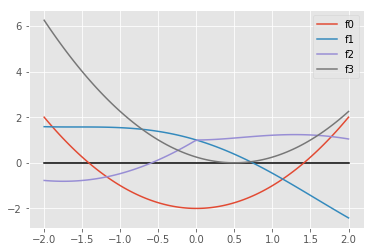

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

tests = []

@tests.append
def f0(x):
    return x*x - 2, 2*x

@tests.append
def f1(x):
    return np.cos(x) - x, -np.sin(x) - 1

@tests.append
def f2(x):
    return (np.exp(-np.abs(x)) + np.sin(x),
            np.exp(-np.abs(x))*(-np.sign(x)) + np.cos(x))

@tests.append
def f3(x):
    return x*x - x + 0.25, 2*x - 1

x = np.linspace(-2,2,100)
plt.plot(x, 0*x, color='k')
for f in tests:
    plt.plot(x, f(x)[0], label=f.__name__)
plt.legend(loc='upper right');

* Which of these functions have at least one root?
* Which have more than one root?
* Can we determine these properties merely by evaluating $f(x)$ for some values of $x$?

## Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives.

In [3]:
def hasroot(f, a, b):
    """Assuming the function f(x) is continuous, return true
    if the sign changes within the interval (a,b), thereby
    guaranteeing the existence of a root.
    
    Note that returning False does not guarantee that a root
    does not exist.
    """
    return f(a)[0]*f(b)[0] < 0
    
def bisect(f, a, b, history=None):
    mid = (a + b)/2.
    if b-a < 1e-5:
        if history is None:
            return mid
        else:
            return mid, np.array(history)
    if history is not None:
        history.append(mid)
    if hasroot(f, a, mid):
        return bisect(f, a, mid, history)
    else:
        return bisect(f, mid, b, history)

* Notice that we need to define `hasroot` above.

Let's try running it:

In [4]:
bisect(tests[0], -1, 1)

0.9999961853027344

In [5]:
np.sqrt(2) - bisect(tests[0], 0, 2)

2.2891797357704746e-06

We get about 5 digits of accuracy.  Why?  How fast did we get there?

In [6]:
x, h = bisect(tests[0], 0, 2, history=[])
x, h.tolist()

(1.4142112731933594,
 [1.0,
  1.5,
  1.25,
  1.375,
  1.4375,
  1.40625,
  1.421875,
  1.4140625,
  1.41796875,
  1.416015625,
  1.4150390625,
  1.41455078125,
  1.414306640625,
  1.4141845703125,
  1.41424560546875,
  1.414215087890625,
  1.4141998291015625,
  1.4142074584960938])

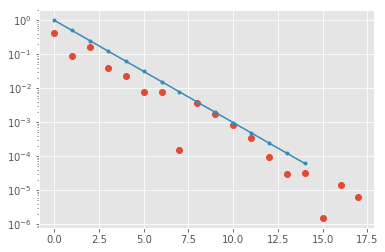

In [9]:
# Compute and plot errors
err = h - np.sqrt(2)
plt.semilogy(np.abs(err), 'o')
plt.semilogy(.5**np.arange(15), '.-');

Can you find any problems with this implementation?  List them below:

* No error checking
* 

Let's try running it on the rest of the test problem set:

In [17]:
for f in tests:
    print(f.__name__, bisect(f, -2, 2.1))

f0 -1.4142136573791504
f1 0.7390824317932131
f2 -0.588533115386963
f3 2.0999960899353027


What's going wrong here?  How can we improve the implementation and what are fundamental limitations of the algorithm?

### Convergence rate

Let's quantitatively revisit the convergence rate.  A convergent rootfinding algorithm produces a sequence of approximations $x_i$ such that $$\lim_{i \to \infty} x_i \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_i = x_i - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{i \to \infty} |e_{i+1}| / |e_i| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_i| \le \epsilon_i $$
for all sufficiently large $i$ when the sequence $\{\epsilon_i\}$ converges $q$-linearly to 0.

Which criteria does the bisection method satisfy?  What is $\rho$ for bisection?

### Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

In [18]:
def newton(func, x, verbose=False):
    """Solve f(x) = 0 using initial guess x.
    
    The provided function func must return a pair of values,
    f(x) and its derivative f'(x).  For example, to solve
    the equation x^2 - 3 starting from initial guess x=1,
    one would write
    
    def func(x):
        return x**2 - 3, 2*x
        
    newton(func, 1)
    """
    for i in range(100):
        fx, dfx = func(x)
        if verbose:
            print(func.__name__, i, x, fx)
        if np.abs(fx) < 1e-12:
            return x, fx, i
        try:
            x -= fx / dfx
        except ZeroDivisionError:
            return x, np.NaN, i

for f in tests:
    print(f.__name__, newton(f, 1, verbose=False))

f0 (1.4142135623730951, 4.440892098500626e-16, 5)
f1 (0.7390851332151607, 0.0, 4)
f2 (-6.285049273382587, -1.4268100589909238e-16, 4)
f3 (0.5000009536743164, 9.094947017729282e-13, 19)


* This output is kinda hard to read, so let's make it cleaner.

In [19]:
for f in tests:
    print(f.__name__, '{0:15.12f} {1:8.2e} {2:2d}'.format(
        *newton(f, -0.1)))

f0 -1.414213562373 1.33e-15  8
f1  0.739085133215 0.00e+00  5
f2 -0.588532743981 5.55e-13  4
f3  0.499999427800 3.27e-13 20


In [20]:
# Or as a table using the Pandas library
import pandas as pd
pd.DataFrame([(f.__name__, *newton(f, -0.1)) for f in tests],
             columns=('Name', 'Root', 'Residual', '# its'))

,Name,Root,Residual,# its
0,f0,-1.414214,1.332268e-15,8
1,f1,0.739085,0.000000e+00,5
2,f2,-0.588533,5.553336e-13,4
3,f3,0.499999,3.274048e-13,20


* Did we solve all of these equations?
* How can the iteration break down?
* Does choosing a different initial guess lead to different solutions?
* How is this convergence test different from the one we used for bisection?
* Is the convergence rate similar for all test equations?

## Convergence of Newton-type algorithms

We would like to know sharp conditions on when Newton-type algorithms converge, and if so, how fast.  This theory will build on that for a general *Fixed Point Iteration*.

### Fixed Point Iteration
Consider the iteration
$$x_{i+1} = g(x_i)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $r = g(r)$.  By the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), we have that
$$ x_{i+1} - r = g(x_i) - g(r) = g'(c_i) (x_i - r) $$
for some $c_i$ between $x_i$ and $r$.
Taking absolute values, $$|e_{i+1}| = |g'(c_i)| |e_i|,$$ which converges to zero if $|g'(c_i)| < 1$.
If $|g'(r)| < 1$ then for any $\epsilon > 0$ there is a neighborhood of $r$ such that $|g'(c_i)| < |g'(r)| + \epsilon$ for all $c_i$ in that neighborhood (guaranteed any time $x_i$ is in the neighborhood).
Consequently, we have:

#### Theorem: Linear Convergence of Fixed Point Iteration

If $g$ is continuously differentiable, $r = g(r)$, and $|g'(r)| < 1$ then the fixed point iteration $x_{i+1} = g(x_i)$ is locally linearly convergent with rate $|g'(r)|$.

#### Example of convergence

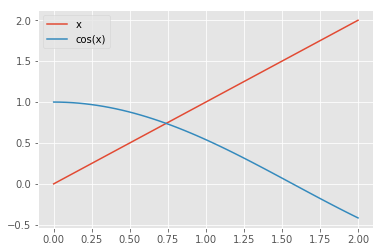

In [51]:
x = np.linspace(0, 2)
plt.plot(x, x, label='x')
plt.plot(x, np.cos(x), label='cos(x)')
plt.legend();

xs: [1]


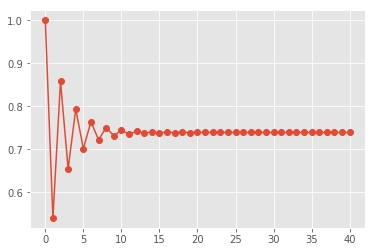

In [49]:
# Solve x = cos(x) using fixed point iteration
def fixed_point(g, x, verbose = False):
    xs = [x]
    if verbose:
        print("xs: {}".format(xs))
    for i in range(40):
        x = g(x)
        xs.append(x)
    return np.array(xs)

xs = fixed_point(np.cos, 1, verbose = True)
plt.plot(xs, 'o-');

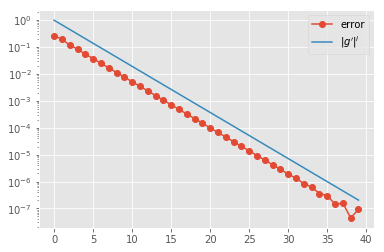

In [23]:
est_root = xs[-1]
plt.semilogy(np.abs(xs[:-1] - est_root), 'o-', label='error');
g_prime = np.sin(est_root)
plt.semilogy(g_prime ** np.arange(40), label="$|g'|^i$")
plt.legend();

#### Example of divergence

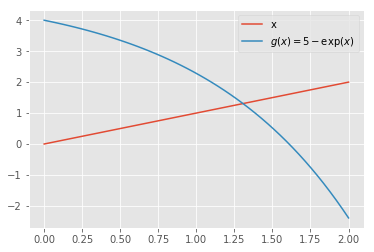

In [24]:
x = np.linspace(0, 2)
plt.plot(x, x, label='x')
plt.plot(x, 5 - np.exp(x), label='$g(x) = 5 - \exp(x)$')
plt.legend();

In [25]:
fixed_point(lambda x: 5 - np.exp(x), 1)[:10]

array([   1.        ,    2.28171817,   -4.79349286,    4.99171653,
       -142.18886032,    5.        , -143.4131591 ,    5.        ,
       -143.4131591 ,    5.        ])

* Even if we start close to the root, it doesn't converge.
* We can explain this by calculating $g'(x)$ for an $x$ close to the root.  Eyeballing the graph, it appears that $r \approx 1.3$.

In [26]:
5 - np.exp(1.306) - 1.306

0.0026213727419630573

$$ g'(x) = - \exp(1.306) $$

In [27]:
-np.exp(1.306)

-3.691378627258037

#### Observations

* A rootfinding problem $f(x) = 0$ can be converted to a fixed point problem $$x = x - f(x) =: g(x)$$ but there is no guarantee that $g'(r) = 1 - f'(r)$ will have magnitude less than 1.
* Problem-specific algebraic manipulation can be used to make $|g'(r)|$ small.
* $x = x - f(x)h(x)$ is also a valid formulation for any $h(x)$ bounded away from $0$.
* Can we choose $h(x)$ such that $$ g'(x) = 1 - f(x) h'(x) - f'(x)h(x) = 0$$ when $f(x) = 0$?

In other words,
$$ x_{i+1} = x_i - f(x) \underbrace{\frac{1}{f'(x)}}_{h(x)} . $$

* It turns out that Newton's method has _locally quadratic_ convergence to simple roots,
$$\lim_{i \to \infty} \frac{|e_{i+1}|}{|e_i|^2} < \infty.$$
* "The number of correct digits doubles each iteration."
* Now that we know how to make a good guess accurate, the effort lies in getting a good guess.

#### Culture: fast inverse square root

The following code appeared literally (including comments) in the Quake III Arena source code (late 1990s).

```C
float Q_rsqrt( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck? 
	y  = * ( float * ) &i;
    y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//  y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}
```

We now have [vector instructions](https://software.intel.com/sites/landingpage/IntrinsicsGuide/#text=sqrt&expand=2989,1224,4470) for approximate inverse square root.
More at https://en.wikipedia.org/wiki/Fast_inverse_square_root

## Conditioning

In [28]:
def fquartic(x):
    return (x - 0.9)**4, 4*(x - 0.9)**3

newton(fquartic, 0)

(0.899096947850202, 6.650454451607741e-13, 24)

We only get three digits correct despite a very small residual (and it takes many iterations to get there).
Difficulty computing zeros of polynomials can also arise when all the roots are simple.  For example, the Wilkinson polynomial
$$ \prod_{i=1}^{20} (x - i) = \sum_{i=0}^{20} a_i x^i $$
has roots at each of the positive integers up to 20.

In [29]:
def wilkinson(n):
    """Compute Wilkinson polynomial of degree n in the
    monomial basis p[0]*x^n + ... + p[n-1]*x + p[n].
    The polynomial can be evaluated using np.polyval(p,x)
    """
    p = np.array([1])
    for i in range(1, n+1):
        p = np.polymul(p, np.array([1, -i]))
    return p

wilkinson(5)

array([   1,  -15,   85, -225,  274, -120])

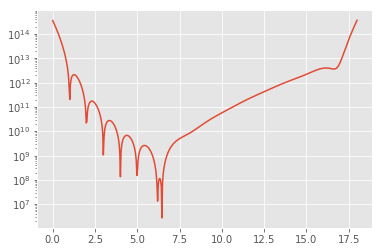

In [30]:
def plot_wilkinson(n):
    """Plot the Wilkinson polynomial of degree n."""
    p = wilkinson(n)
    p[n//2] *= 1 + 1e-10
    x = np.linspace(0, n+1, 500)
    y = np.polyval(p, x)
    #pyplot.plot(x, y)
    plt.semilogy(x, np.abs(y))
    
plot_wilkinson(17)

The roots are extremely sensitive to perturbations of the coefficients $a_i$, as shown in this figure from Trefethen and Bau (1999).
![Ill conditioning of roots of Wilkinson's polynomial](figures/TB-Wilkinson.png)

Numerical difficulties in which "correct" algorithms produce unreliable solutions almost always stem from lack of *stability* and/or *ill conditioning*.

### Absolute condition number
Consider a function $f: X \to Y$ and define the *absolute condition number*
$$ \hat\kappa = \lim_{\delta \to 0} \max_{|\delta x| < \delta} \frac{|f(x + \delta x) - f(x)|}{|\delta x|} = \max_{\delta x} \frac{|\delta f|}{|\delta x|}. $$
If $f$ is differentiable, then $\hat\kappa = |f'(x)|$.

NOTE: Here we get the definition of the condition, $\hat{\kappa}$

### Floating point arithmetic
Floating point arithmetic $x \circledast y := \text{float}(x * y)$ is exact within a relative accuracy $\epsilon_{\text{machine}}$.  Formally,
$$ x \circledast y = (x * y) (1 + \epsilon) $$
for some $|\epsilon| \le \epsilon_{\text{machine}}$.

In [31]:
format(.5, '.20f') # 0.5 can be represented by python
format(.3, '.20f') # representation of 0.3 notice the error
format(.2 - 1/3 + 2/15, '.20f') # should get 0 but we don't get zero. B/cos there is a approx here
#format((.2 - 1/3) + (1/3 - 0.2), '.20f')
#format((1 + 1e-12) - 1, '.20f')
#format(1e-12 + 1 - 1, '.20f')

'0.00000000000000002776'

In [32]:
eps = 1
while 1 + eps > 1:
    eps /= 2
eps_machine = eps
print('Machine epsilon = {}'.format(eps_machine))
(1 + 1.12e-16) - 1

Machine epsilon = 1.1102230246251565e-16


2.220446049250313e-16

In [33]:
np.log(1 + 1e-12) - np.log1p(1e-12)

8.890058234103173e-17

In [34]:
(np.log(1 + 1e-12) - np.log1p(1e-12)) / np.log1p(1e-12)

8.890058234107618e-05

In [35]:
x = np.array([1,1e5,1e10,1e15])
np.sin(np.pi*x)

array([ 1.22464680e-16, -3.39606540e-11, -2.23936276e-06, -2.36209053e-01])

In [36]:
np.sin(x)**2 + np.cos(x)**2 - 1

array([ 0.00000000e+00, -1.11022302e-16,  0.00000000e+00,  0.00000000e+00])

In [37]:
[np.tan((3.14159+eps)/2)
 for eps in [1e-6,1e-8]], 1/np.cos(3.14159)**2

([1209489.8070879749, 756547.0274470996], 1.0000000000070415)

### Relative condition number

Given the relative nature of floating point arithmetic, it is more useful to discuss **relative condition number**,
$$ \kappa = \max_{\delta x} \frac{|\delta f|/|f|}{|\delta x|/|x|}
= \max_{\delta x} \Big[ \frac{|\delta f|/|\delta x|}{|f| / |x|} \Big] $$
or, if $f$ is differentiable,
$$ \kappa = \max_{\delta x} |f'(x)| \frac{|x|}{|f|} . $$

How does a condition number get big?

#### Take-home message

The relative accuracy of the best-case algorithm will not be reliably better than $\epsilon_{\text{machine}}$ times the condition number.
$$ \max_{\delta x} \frac{|\delta f|}{|f|} \ge \kappa \cdot \epsilon_{\text{machine}} .$$

## Stability

We use the notation $\tilde f(x)$ to mean a numerical algorithm for approximating $f(x)$.  Additionally, $\tilde x = x (1 + \epsilon)$ is some "good" approximation of the exact input $x$.

### (Forward) Stability
**"nearly the right answer to nearly the right question"**
$$ \frac{\lvert \tilde f(x) - f(\tilde x) \rvert}{| f(\tilde x) |} \in O(\epsilon_{\text{machine}}) $$
for some $\tilde x$ that is close to $x$

### Backward Stability
**"exactly the right answer to nearly the right question"**
$$ \tilde f(x) = f(\tilde x) $$
for some $\tilde x$ that is close to $x$

* Every backward stable algorithm is stable.
* Not every stable algorithm is backward stable.

#### Example: $\tilde f(x) = \text{float}(x) \oplus 1$
The algorithm computes
$$\tilde f(x) = \text{float}(x) \oplus 1 = [x(1+\epsilon_1) + 1](1 + \epsilon_2) = (x + 1 + x\epsilon_1)(1 + \epsilon_2) $$
and we can express any $\tilde x = x(1 + \epsilon_3)$.
To see if if the algorithm is stable, we compute
$$ \frac{\tilde f(x) - f(\tilde x)}{|f(\tilde x)|} = \frac{(x + 1 + x\epsilon_1)(1 + \epsilon_2) - [x(1+ \epsilon_3) + 1]}{\tilde x + 1} = \frac{(x + 1)\epsilon_2 + x(\epsilon_1 - \epsilon_3) + O(\epsilon^2)}{x + 1 + x\epsilon_3} . $$
If we can choose $\epsilon_3$ to make this small, then the method will be (forward) stable, and if we can make this expression exactly zero, then we'll have backward stability.
Trying for the latter, we solve for $\epsilon_3$ by setting the numerator equal to zero,
$$ \epsilon_3 = \frac{x + 1}{x}\epsilon_2 + \epsilon_1 + O(\epsilon^2)/x $$
which is small so long as $|x| \gg 0$, but the first term blows up as $x \to 0$.
In other words, the fact that $\epsilon_2$ can produce a large error relative to the input causes this algorithm to not be backward stable.
In contrast, this $x\to 0$ case is not a problem for forward stability because $\epsilon_3 = \epsilon_1$ yields error on the order of $\epsilon_2$.

#### Example: $\tilde f(x,y) = \text{float}(x) \oplus \text{float}(y)$

Now we are interested in
$$ \frac{\tilde f(x,y) - f(\tilde x,\tilde y)}{f(\tilde x,\tilde y)} $$
and we can vary both $\tilde x$ and $\tilde y$.  If we choose $y=1$, then the ability to vary $\tilde y$ is powerful enough to ensure backward stability.

### Accuracy of backward stable algorithms (Theorem)

A backward stable algorithm for computing $f(x)$ has relative accuracy
$$ \left\lvert \frac{\tilde f(x) - f(x)}{f(x)} \right\rvert \in O(\kappa(f) \epsilon_{\text{machine}}) . $$
This is a rewording of a statement made earlier -- backward stability is the best case.